In [72]:
import os
from pathlib import Path


os.chdir(Path.cwd().parent)

In [73]:
import time
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import sys
import typing as tp

from src.optimizers.step_controllers.step_controllers import (
    StepControllerBase, ConstantController, BacktrackingLineSearchController
)
from src.optimizers._base import GradientDescentBase
from src.optimizers.gradient_descent import GradientDescent
from src.optimizers.riemannian_newton_method import RiemannianNewtonIterations
from src.optimizers.riemannian_trust_region import RiemannianTrustRegionMethod
from src.optimizers.jacobi_davidson import JDIteration
from src.rayleigh_quotient import rayleigh_quotient
from src.utils.linalg import (
    generate_normalized_vector, generate_supersymmetric_tensor, tenvec
)

In [74]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [75]:
def speedtest(
    A: np.ndarray,
    methods: list[GradientDescentBase | JDIteration],
    step_controllers: list[StepControllerBase] = [ConstantController(), BacktrackingLineSearchController()],
    *,
    n_iters: int = 5,
    verbose: bool = False) -> None:
    """
    Measure minimization speed in real time and number of iterations of different methods

    :param A: supersymmetric tensor of shape (n x n x ... x n) of order k
    :param methods: optimization methods to use
    :paran step_controllers: step controllers to use.
        Default is to use all implemented with default parameters
    :n_iters: number of iteration with different vectors x
    :param verbose: whether to print more info
    """
    if verbose:
        print(f"speedtesting methods:\n"
              f"{', '.join(m.shortname() for m in methods)}\n"
              f"with parameters:\n"
              f"tensor A of shape {A.shape}\nA = {A}\n"
              f"vector x = {x}")
    k = A.ndim

    fig, axs = plt.subplots(1, 3, figsize=(12, 6))
    fig.suptitle(f"Statistics for different methods for tensor of shape {A.shape}")
    axs[0].set(title="mean number of iterations until convergence")
    axs[1].set(title="mean duration of different methods")
    axs[2].set(title="mean number of fails to converge")

    stats_all = defaultdict(list)

    for method in methods:
        print(f"Estimating {method.shortname()}")
        for step_controller in step_controllers:
            name = step_controller.name()
            stats = {"n_iters": [], "time": [], "n_fails": 0}
            for _ in range(n_iters):
                x = generate_normalized_vector(A.shape[0])

                start = time.time()
                x_eign = method.minimize(x, step_controller=step_controller)
                end = time.time()

                rq_eign = rayleigh_quotient(A, x_eign)

                x_expected = rq_eign * x_eign
                x_computed = tenvec(A, x_eign, times=k-1)

                success = np.allclose(x_expected, x_computed, atol=1e-4)
                if success:
                    stats["time"].append(end - start)
                    stats["n_iters"].append(len(method._x_history))
                else:
                    stats["n_fails"] += 1
            stats["mean_n_iters"] = np.mean(stats["n_iters"]) if stats["n_iters"] else np.inf
            stats["mean_time"] = np.mean(stats["time"]) if stats["time"] else np.inf
            stats["mean_n_fails"] = stats["n_fails"] / n_iters
            stats_all[name].append(stats)

    if len(step_controllers) == 2:
        name0, name1 = [s.name() for s in step_controllers]
        for ax, stat in zip(axs, ["mean_n_iters", "mean_time", "mean_n_fails"]):
            ax.bar(np.arange(len(methods)) - 0.2, [s[stat] for s in stats_all[name0]], width=0.4, label=name0)
            ax.bar(np.arange(len(methods)) + 0.2, [s[stat] for s in stats_all[name1]], width=0.4, label=name1)
    elif len(step_controllers) == 1:
        name = step_controllers[0].name()
        for ax, stat in zip(axs, ["mean_n_iters", "mean_time", "mean_n_fails"]):
            ax.bar(np.arange(len(methods)), [s[stat] for s in stats_all[name]], width=0.8, label=name)

    for ax in axs:
        ax.set_xticks(range(len(methods)))
        ax.set_xticklabels([method.shortname() for method in methods])
        ax.legend()
    fig.tight_layout()


def speedtest_all(n: int, k: int, n_iters: int = 10, eps: float = 1e-4):
    A = generate_supersymmetric_tensor(n, k)
    methods = [
        GradientDescent.from_tensor(A, eps=eps),
        # RiemannianNewtonIterations.from_tensor(A, invalid="ignore", eps=eps),
        RiemannianNewtonIterations.from_tensor(A, invalid="fix", eps=eps),
        RiemannianTrustRegionMethod.from_tensor(A, invalid="fix", eps=eps),
        JDIteration(A, eigsolver=RiemannianTrustRegionMethod, eigsolver_params={"invalid": "fix"}, eps=eps),
    ]
    speedtest(A, methods, n_iters=n_iters)

def speedtest_backtracking(n: int, k: int, n_iters: int = 10, eps: float = 1e-6):
    A = generate_supersymmetric_tensor(n, k)
    methods = [
        GradientDescent.from_tensor(A, eps=eps),
        RiemannianNewtonIterations.from_tensor(A, invalid="fix", eps=eps),
        RiemannianTrustRegionMethod.from_tensor(A, invalid="fix", eps=eps),
        JDIteration(A, eigsolver=RiemannianTrustRegionMethod, eigsolver_params={"invalid": "fix"}, eps=1e-6),
    ]
    step_controllers = [BacktrackingLineSearchController()]
    speedtest(A, methods, step_controllers, n_iters=n_iters)

Estimating GD
Estimating RNI
Estimating RTR
Estimating JDI


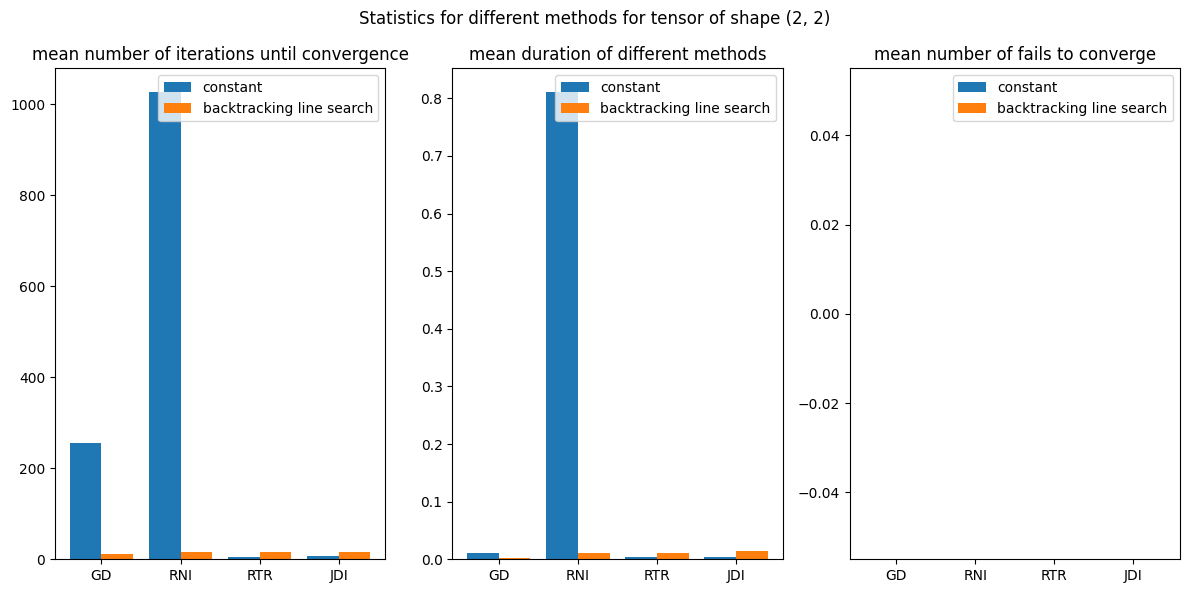

In [76]:
speedtest_all(2, 2, n_iters=10)

Estimating GD
Estimating RNI
Estimating RTR


/home/chep0k/hse/3-course/jdm/src/optimizers/riemannian_trust_region.py:60: UserWarning: max iterations reached
  warnings.warn("max iterations reached")


Estimating JDI


/home/chep0k/hse/3-course/jdm/src/optimizers/jacobi_davidson.py:110: UserWarning: |V| is no more orthonormal. It has more columns than rows
  if V.shape[1] > V.shape[0]:


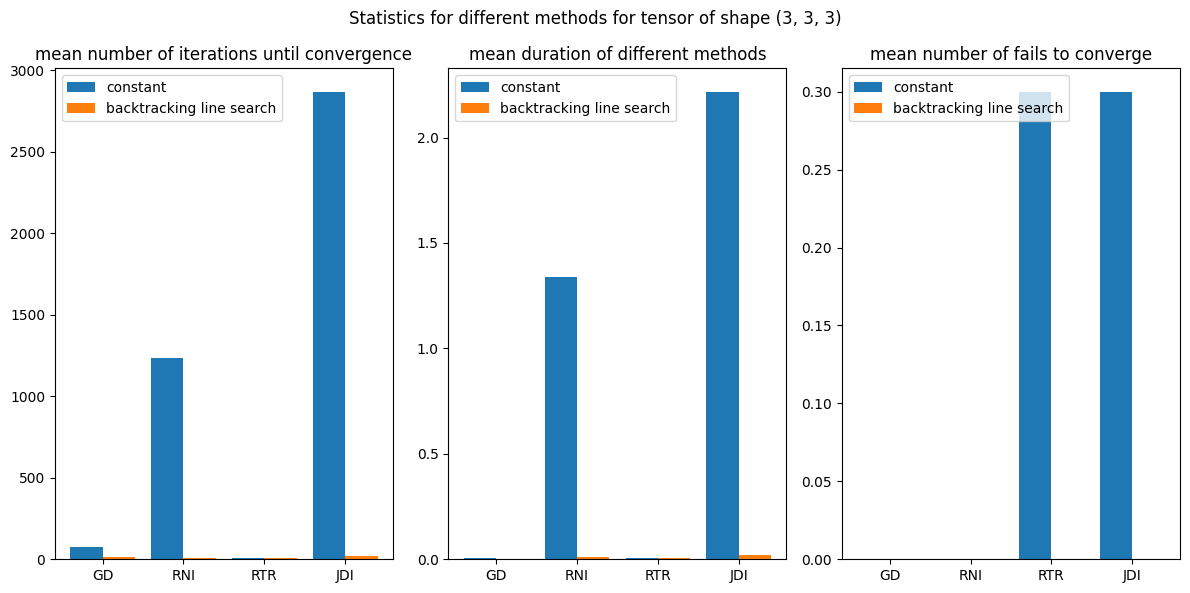

In [77]:
speedtest_all(3, 3, n_iters=10)

Estimating GD
Estimating RNI
Estimating RTR
Estimating JDI


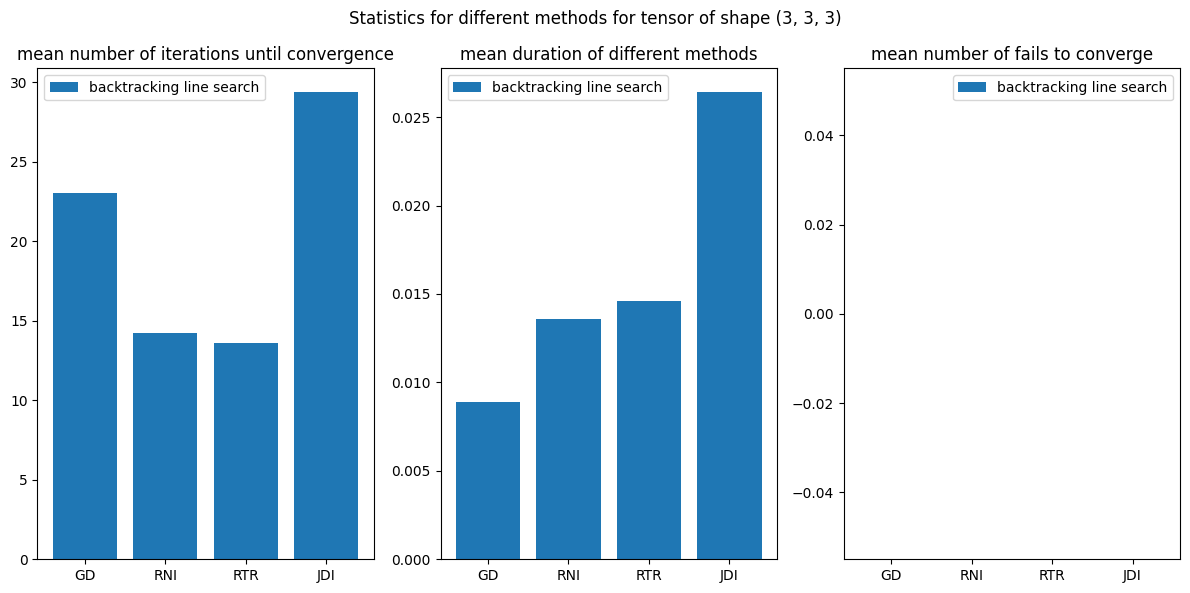

In [78]:
speedtest_backtracking(3, 3, n_iters=5, eps=1e-6)